### Imports

In [2]:
import numpy as np

import pandas as pd

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

from category_encoders import TargetEncoder

from matplotlib import pyplot as plt 
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import seaborn as sns

import missingno as mno

import xgboost as xgb

import lightgbm as lgbm

import catboost as catb

/tmp/ipykernel_1155/3744500144.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


### Data Load

In [3]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
data_info = pd.read_csv("./data_info.csv")

# Drop 'road_in_use' column
X_train = train.drop('road_in_use', axis = 1)
X_test = test.drop('road_in_use', axis = 1)

# Seperate X, y
y_train = X_train['target']
X_train = X_train.drop('target', axis = 1)

### Summarize

In [4]:
data_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
dtypes: float64(8), int

In [6]:
X_train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,0.0,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0.0,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0.0,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0.0,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0.0,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음


In [7]:
X_train.isna().sum() + X_test.isna().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
dtype: int64

In [8]:
pd.concat([X_train, X_test]).nunique()

id                       4992458
base_date                    312
day_of_week                    7
base_hour                     24
lane_count                     3
road_rating                    3
road_name                     61
multi_linked                   2
connect_code                   2
maximum_speed_limit            6
vehicle_restricted             1
weight_restricted              4
height_restricted              1
road_type                      2
start_node_name              487
start_latitude               586
start_longitude              586
start_turn_restricted          2
end_node_name                487
end_latitude                 586
end_longitude                586
end_turn_restricted            2
dtype: int64

### Cleaning

Has only 1 value -> Erase  
Has binary value -> Change to boolean

In [9]:
a = X_train.nunique()
X_train = X_train.drop(a[a == 1].index.values, axis = 1)
X_test = X_test.drop(a[a == 1].index.values, axis = 1)

In [10]:
X_train[['start_turn_restricted', 'end_turn_restricted']] = X_train[['start_turn_restricted', 'end_turn_restricted']] == '있음'
X_test[['start_turn_restricted', 'end_turn_restricted']] = X_test[['start_turn_restricted', 'end_turn_restricted']] == '있음'

X_train[a[a==2].index.values] = X_train[a[a==2].index.values].astype('bool')
X_test[a[a==2].index.values] = X_test[a[a==2].index.values].astype('bool')

X_train[a[a==2].index.values].head()

,multi_linked,connect_code,road_type,start_turn_restricted,end_turn_restricted
0,False,False,True,False,False
1,False,False,False,True,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False


Linearlize 'base_date'

In [11]:
def linearDate(date):
    _date = str(date)
    a = int(_date[0:4])*365
    a += (int(_date[4:6])-1)*12
    a += int(_date[6:8])
    return a

X_train['base_date'] = X_train['base_date'].apply(linearDate)
X_train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TRAIN_0000000,738113,목,17,1,106,지방도1112호선,False,False,60.0,32400.0,True,제3교래교,33.427747,126.662612,False,제3교래교,33.427749,126.662335,False
1,TRAIN_0000001,738130,목,21,2,103,일반국도11호선,False,False,60.0,0.0,False,광양사거리,33.500730,126.529107,True,KAL사거리,33.504811,126.526240,False
2,TRAIN_0000002,737783,일,7,2,103,일반국도16호선,False,False,80.0,0.0,False,창고천교,33.279145,126.368598,False,상창육교,33.280072,126.362147,False
3,TRAIN_0000003,738065,금,13,2,107,태평로,False,False,50.0,0.0,False,남양리조트,33.246081,126.567204,False,서현주택,33.245565,126.566228,False
4,TRAIN_0000004,737778,화,8,2,103,일반국도12호선,False,False,80.0,0.0,False,애월샷시,33.462214,126.326551,False,애월입구,33.462677,126.330152,False


Correlation check

/tmp/ipykernel_1155/3848786790.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = X_train.corr()


<AxesSubplot: >

/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


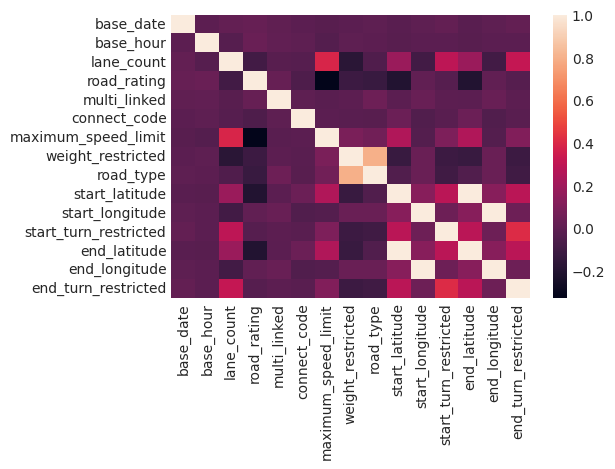

In [12]:
corr = X_train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

시작지점과 도착지점의 위도, 경도값이 거의 동일하다. 측정 구간이 길지 않기 때문에 유의미한 차이가 없다.  
따라서 두 feature를 하나의 feature로 묶어준다. 

In [13]:
(X_train['start_latitude'] / X_train['end_latitude']).mean()

0.9999999569795256

In [14]:
X_train['latitude'] = (X_train['start_latitude'] + X_train['end_latitude'])*.5
X_train['longitude'] = (X_train['start_longitude'] + X_train['end_longitude'])*.5

X_test['latitude'] = (X_test['start_latitude'] + X_test['end_latitude'])*.5
X_test['longitude'] = (X_test['start_longitude'] + X_test['end_longitude'])*.5

X_train = X_train.drop(['start_longitude', 'end_longitude', 'start_latitude', 'end_latitude'], axis = 1)
X_test = X_test.drop(['start_longitude', 'end_longitude', 'start_latitude', 'end_latitude'], axis = 1)

X_train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted,latitude,longitude
0,TRAIN_0000000,738113,목,17,1,106,지방도1112호선,False,False,60.0,32400.0,True,제3교래교,False,제3교래교,False,33.427748,126.662474
1,TRAIN_0000001,738130,목,21,2,103,일반국도11호선,False,False,60.0,0.0,False,광양사거리,True,KAL사거리,False,33.502771,126.527673
2,TRAIN_0000002,737783,일,7,2,103,일반국도16호선,False,False,80.0,0.0,False,창고천교,False,상창육교,False,33.279609,126.365373
3,TRAIN_0000003,738065,금,13,2,107,태평로,False,False,50.0,0.0,False,남양리조트,False,서현주택,False,33.245823,126.566716
4,TRAIN_0000004,737778,화,8,2,103,일반국도12호선,False,False,80.0,0.0,False,애월샷시,False,애월입구,False,33.462446,126.328351


Change kr -> eng

In [15]:
def changeKR(day):
    if day == '월' : return 'mon' 
    elif day == '화' : return 'tue' 
    elif day == '수' : return 'wed' 
    elif day == '목' : return 'thu'
    elif day == '금' : return 'fri' 
    elif day == '토' : return 'sat' 
    else : return 'sun' 

X_train['day_of_week'] = X_train['day_of_week'].apply(changeKR)
X_test['day_of_week'] = X_test['day_of_week'].apply(changeKR)

X_train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted,latitude,longitude
0,TRAIN_0000000,738113,thu,17,1,106,지방도1112호선,False,False,60.0,32400.0,True,제3교래교,False,제3교래교,False,33.427748,126.662474
1,TRAIN_0000001,738130,thu,21,2,103,일반국도11호선,False,False,60.0,0.0,False,광양사거리,True,KAL사거리,False,33.502771,126.527673
2,TRAIN_0000002,737783,sun,7,2,103,일반국도16호선,False,False,80.0,0.0,False,창고천교,False,상창육교,False,33.279609,126.365373
3,TRAIN_0000003,738065,fri,13,2,107,태평로,False,False,50.0,0.0,False,남양리조트,False,서현주택,False,33.245823,126.566716
4,TRAIN_0000004,737778,tue,8,2,103,일반국도12호선,False,False,80.0,0.0,False,애월샷시,False,애월입구,False,33.462446,126.328351


Drop 'id'

In [16]:
X_train = X_train.drop('id', axis = 1)
X_test = X_test.drop('id', axis = 1)

### Data visualization

Count plot

/root/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  func(*args, **kwargs)
/root/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  func(*args, **kwargs)
/root/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  func(*args, **kwargs)
/root/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from current font.
  func(*args, **kwargs)
/root/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from current font.
  func(*args, **kwargs)
/root/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.


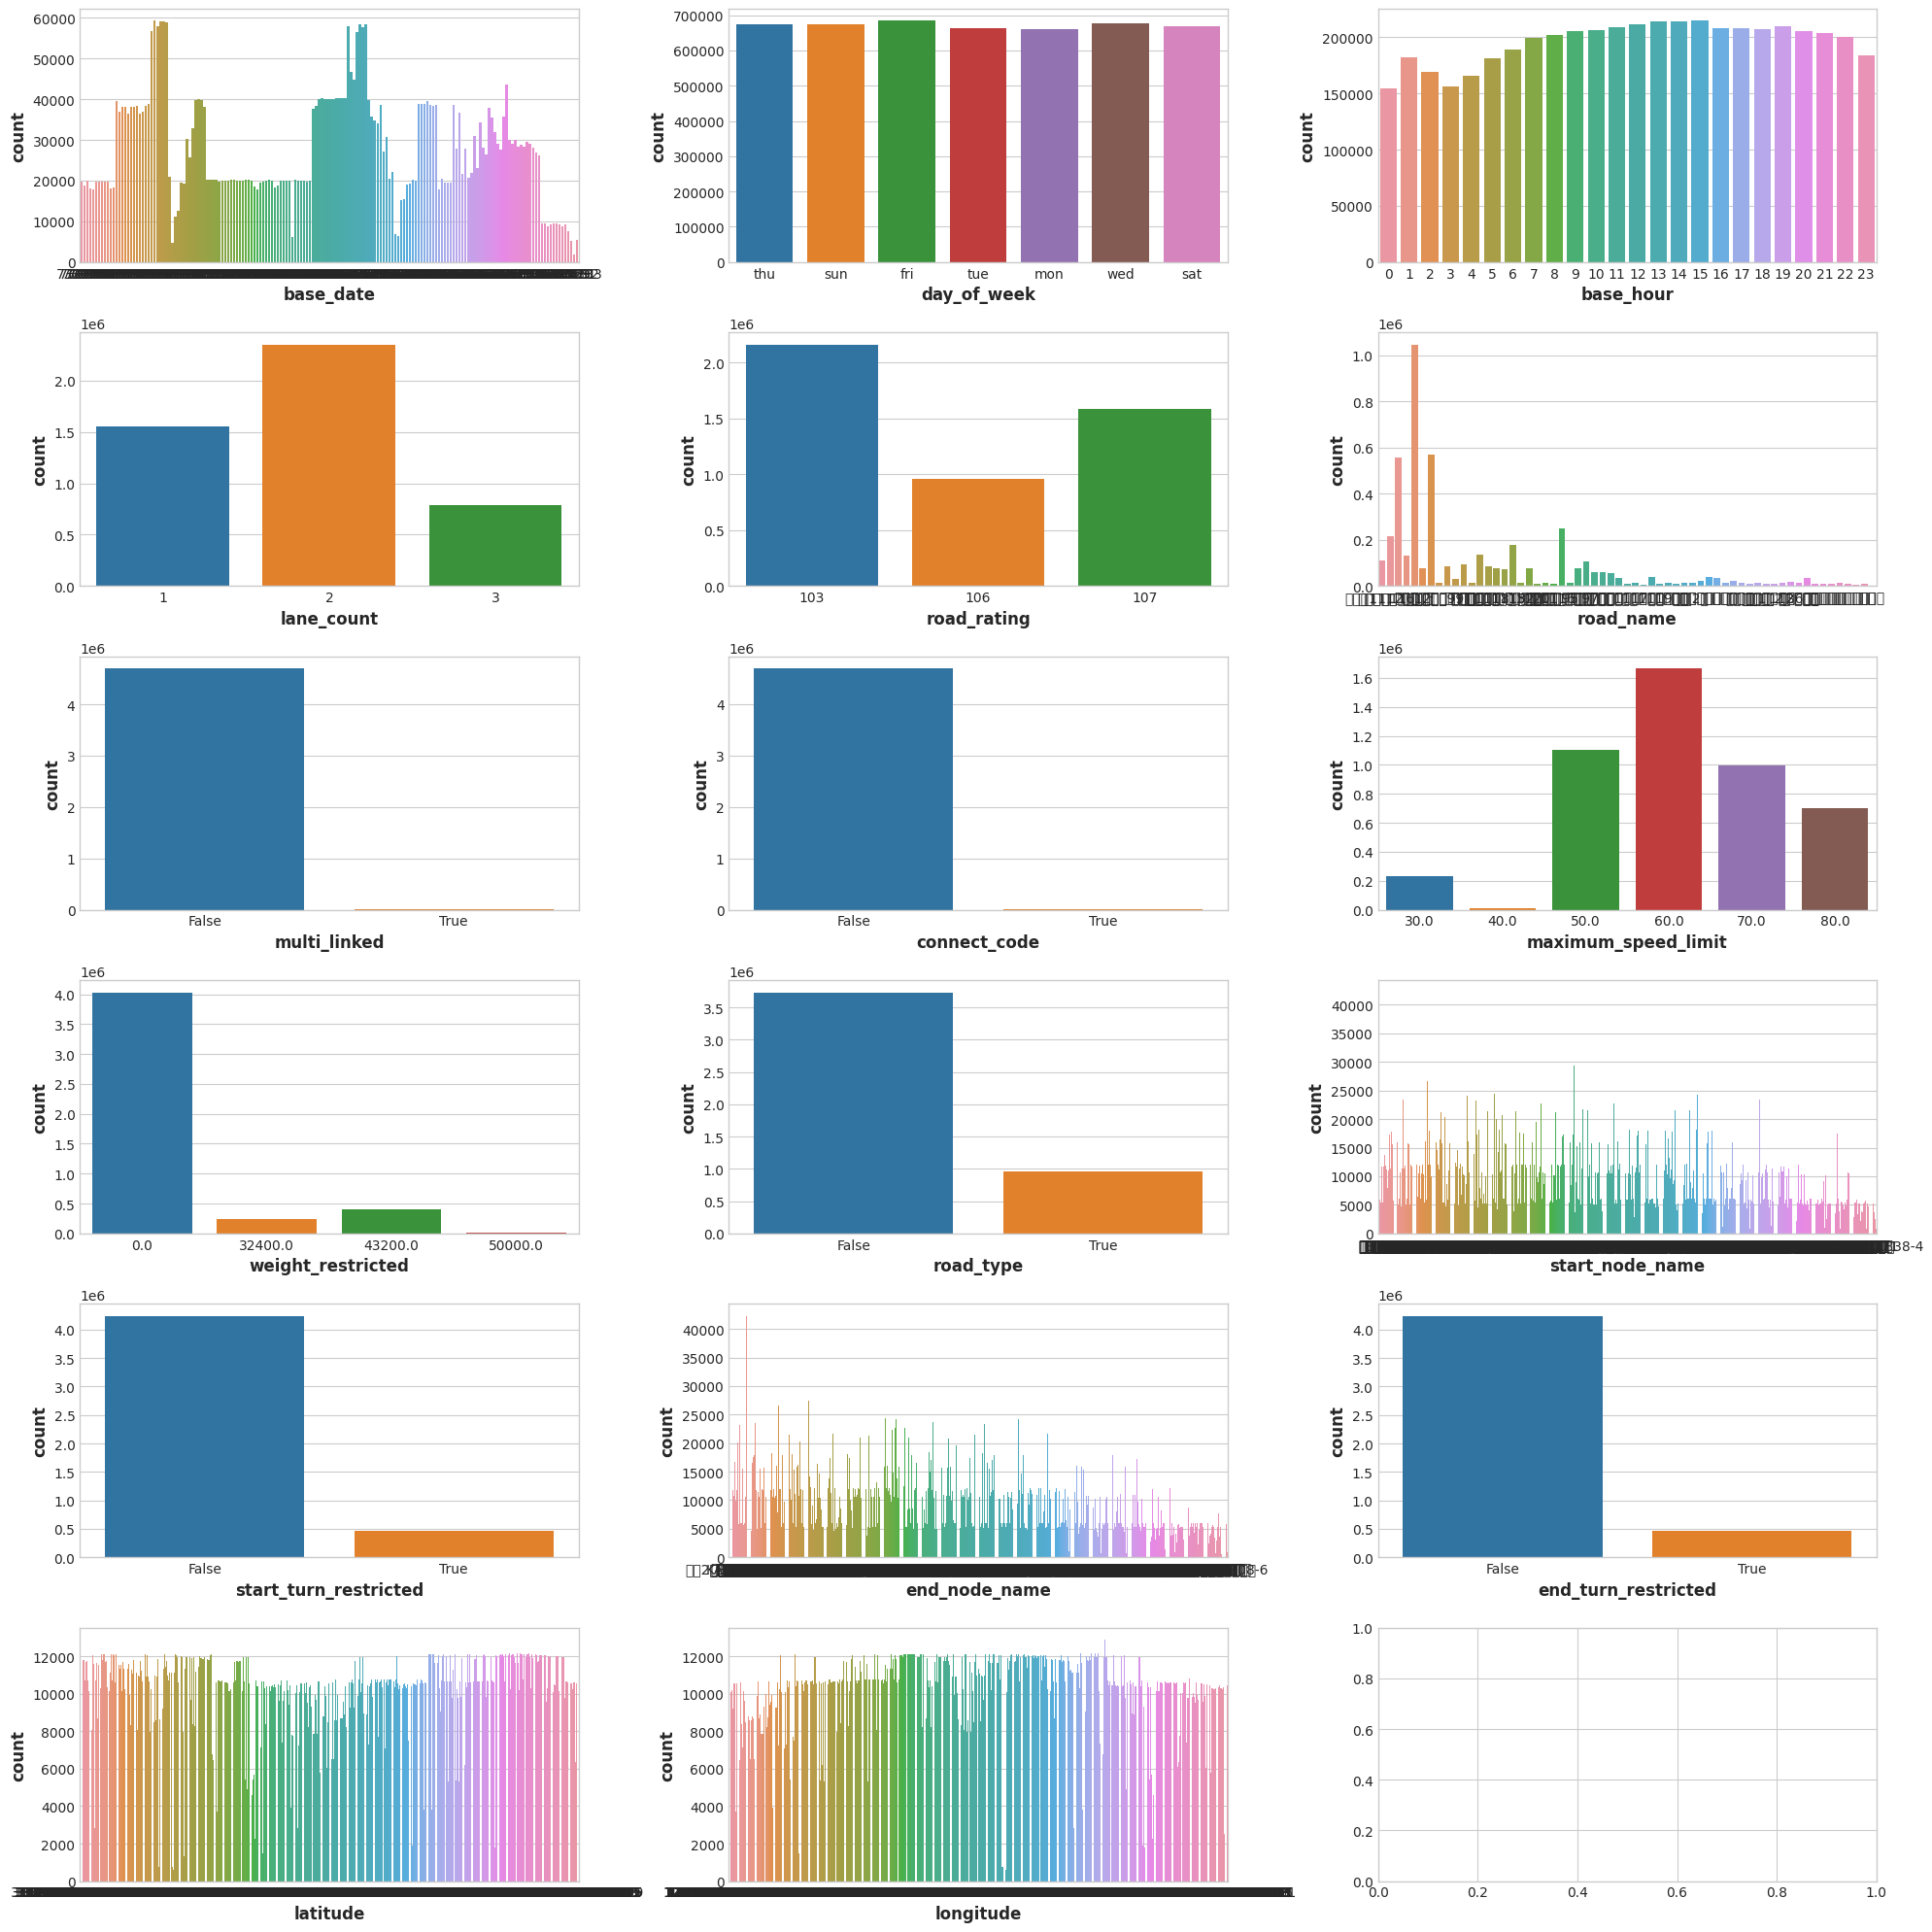

In [18]:
fig, axes = plt.subplots(6, 3, figsize=(20, 20))

for name, ax in zip(X_train.columns, axes.flatten()):
    sns.countplot(x=name, data=X_train, ax=ax)

Target distribution

/tmp/ipykernel_1108/3763708797.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data[value] = _data['target']
/tmp/ipykernel_1108/3763708797.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data[value] = _data['target']
/tmp/ipykernel_1108/3763708797.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

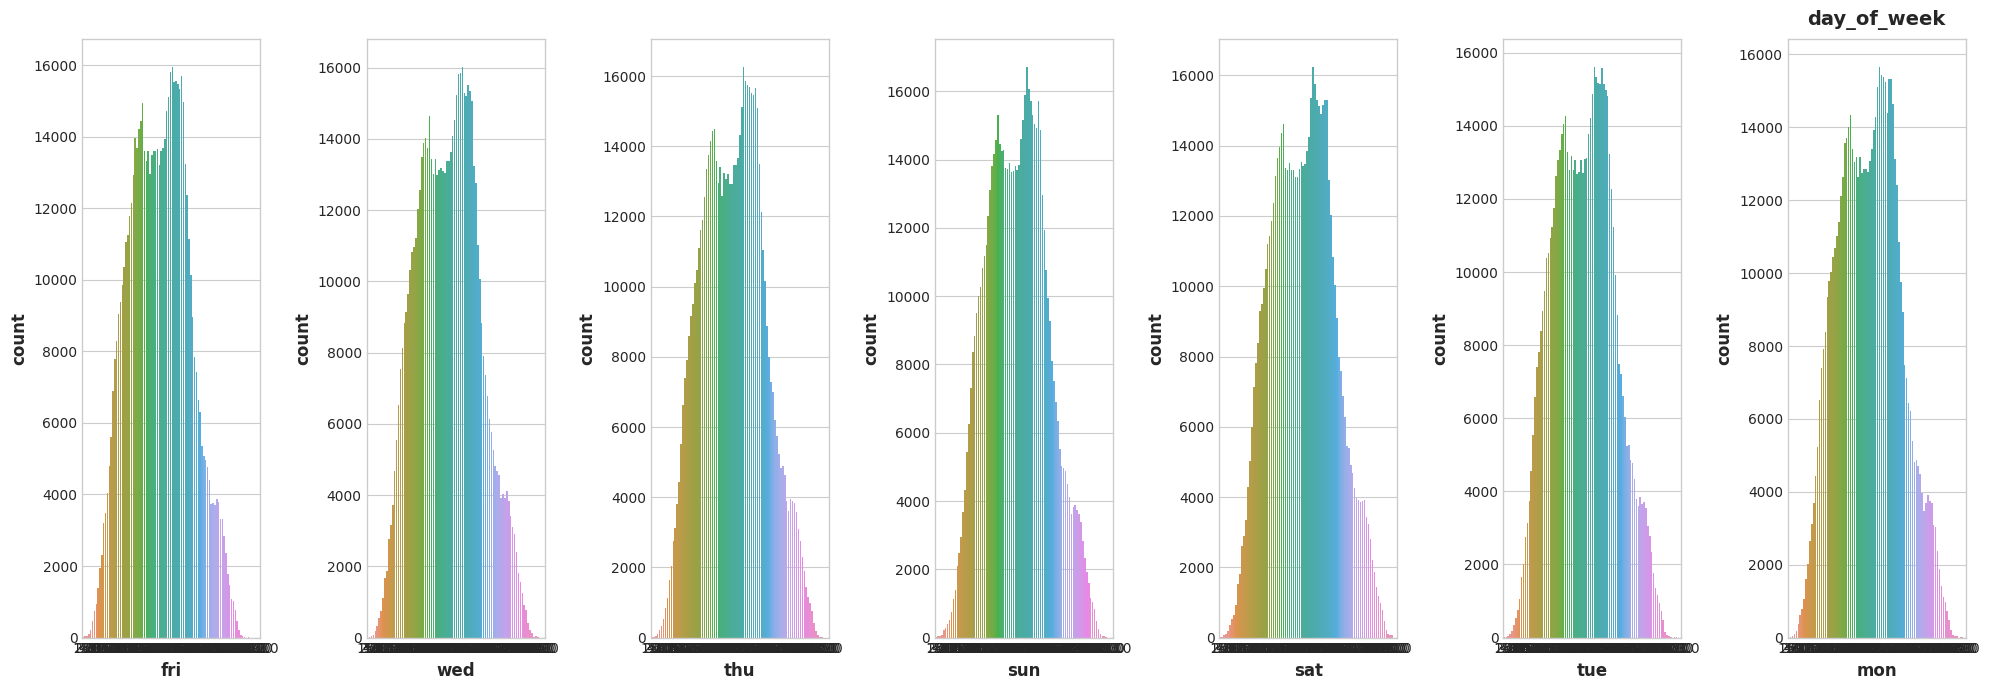

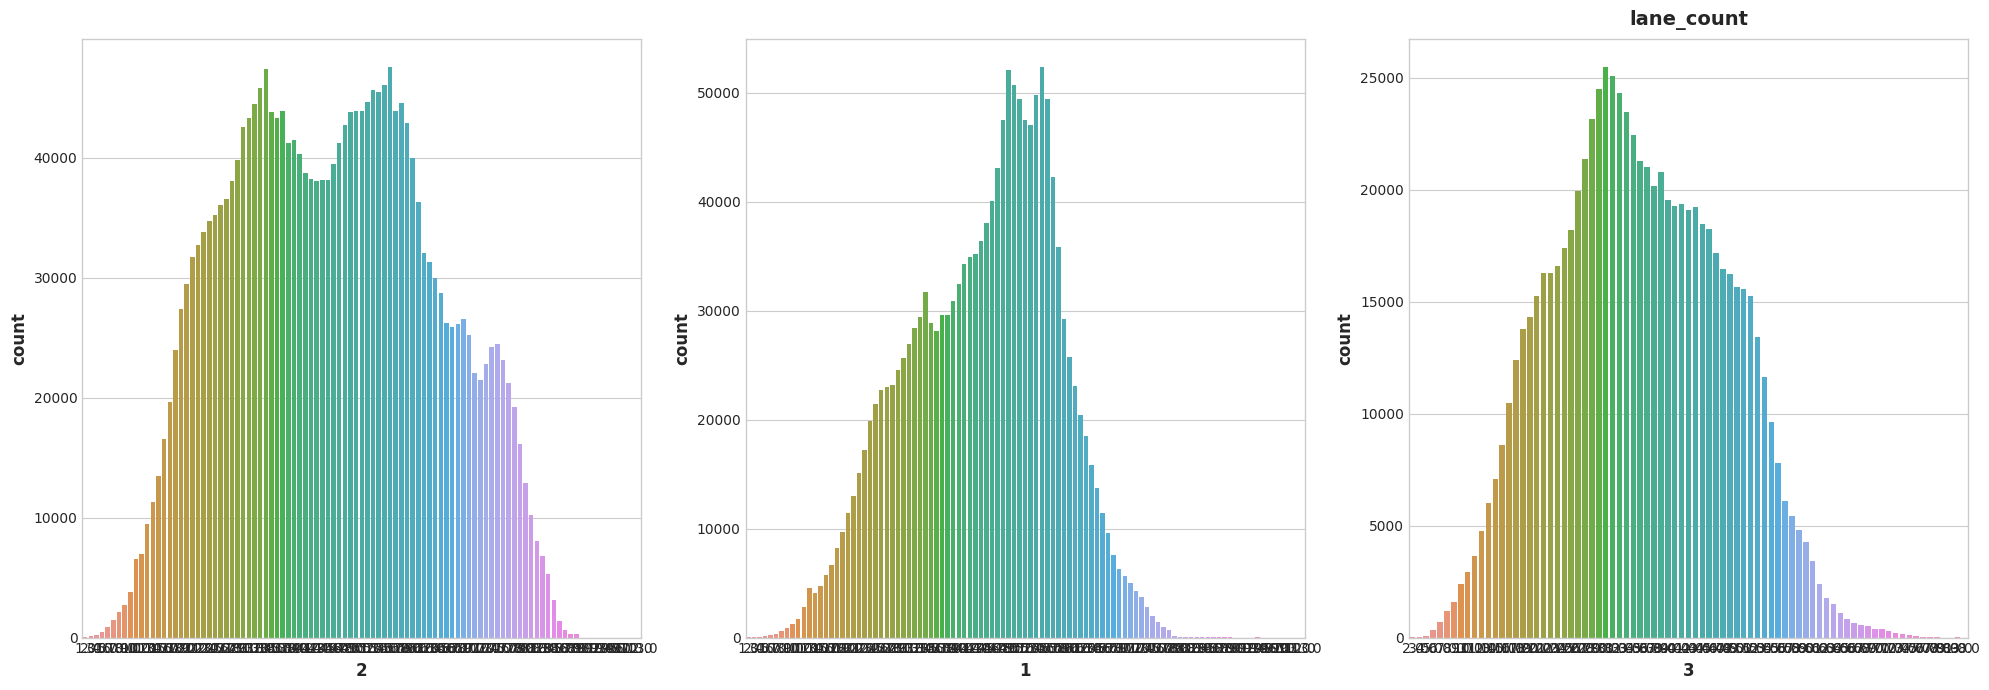

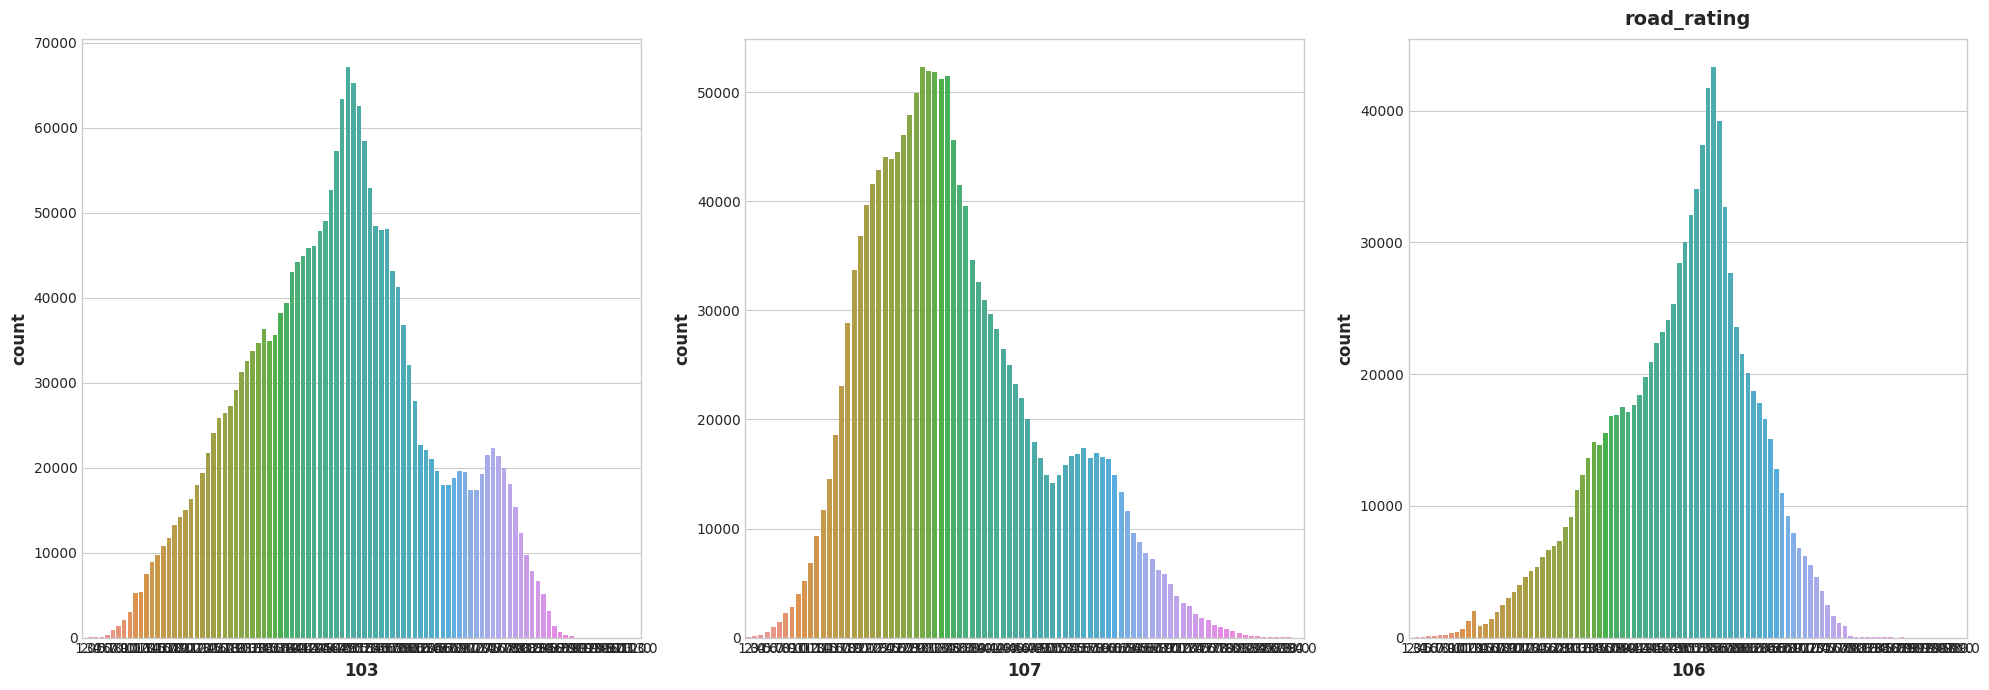

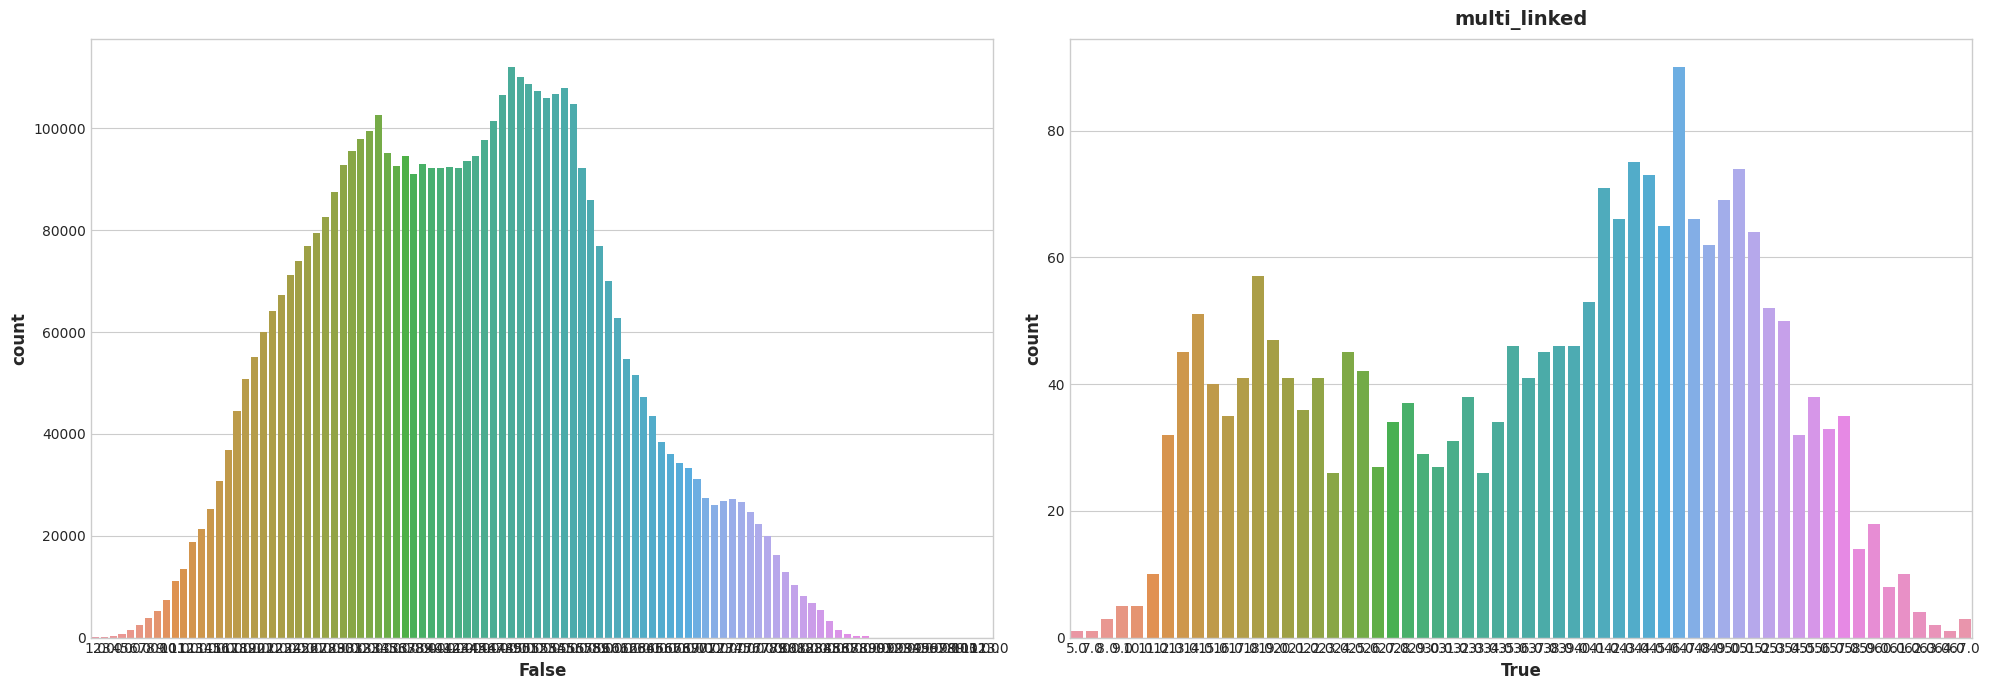

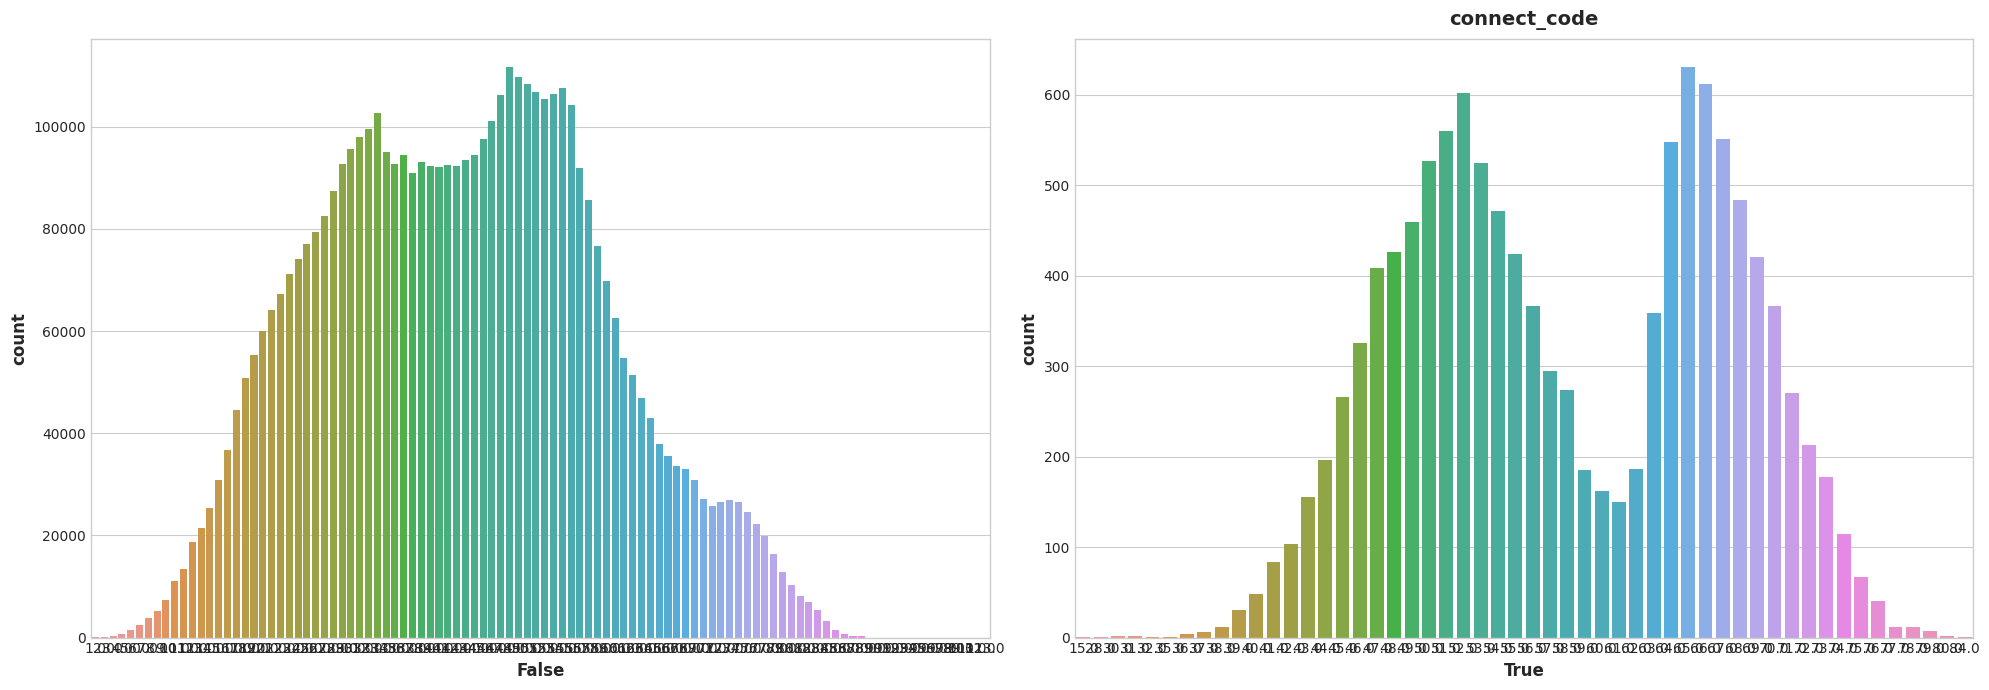

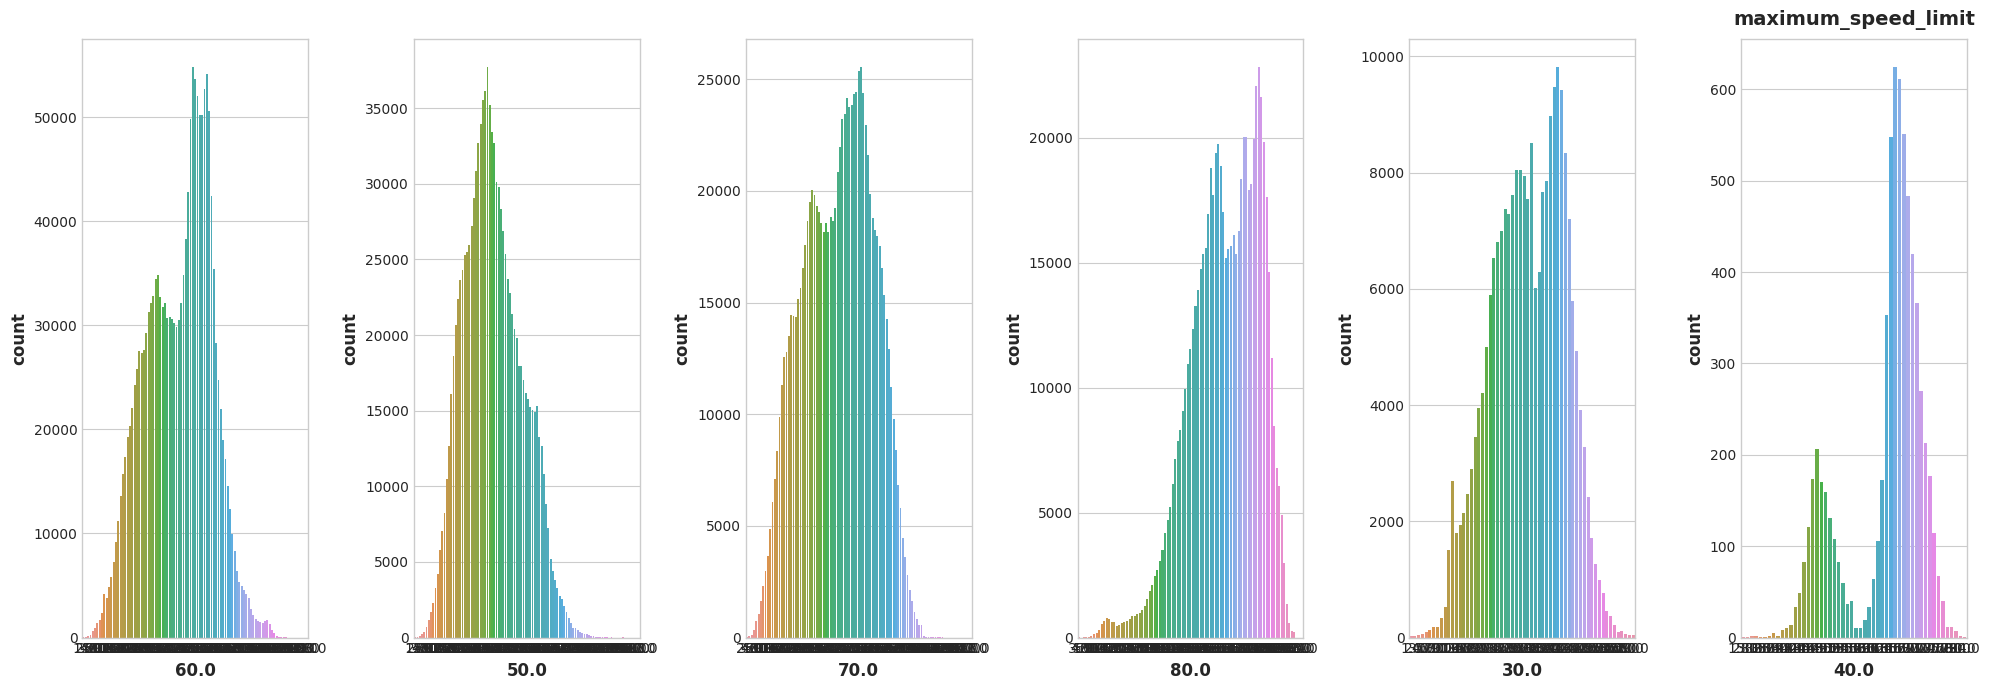

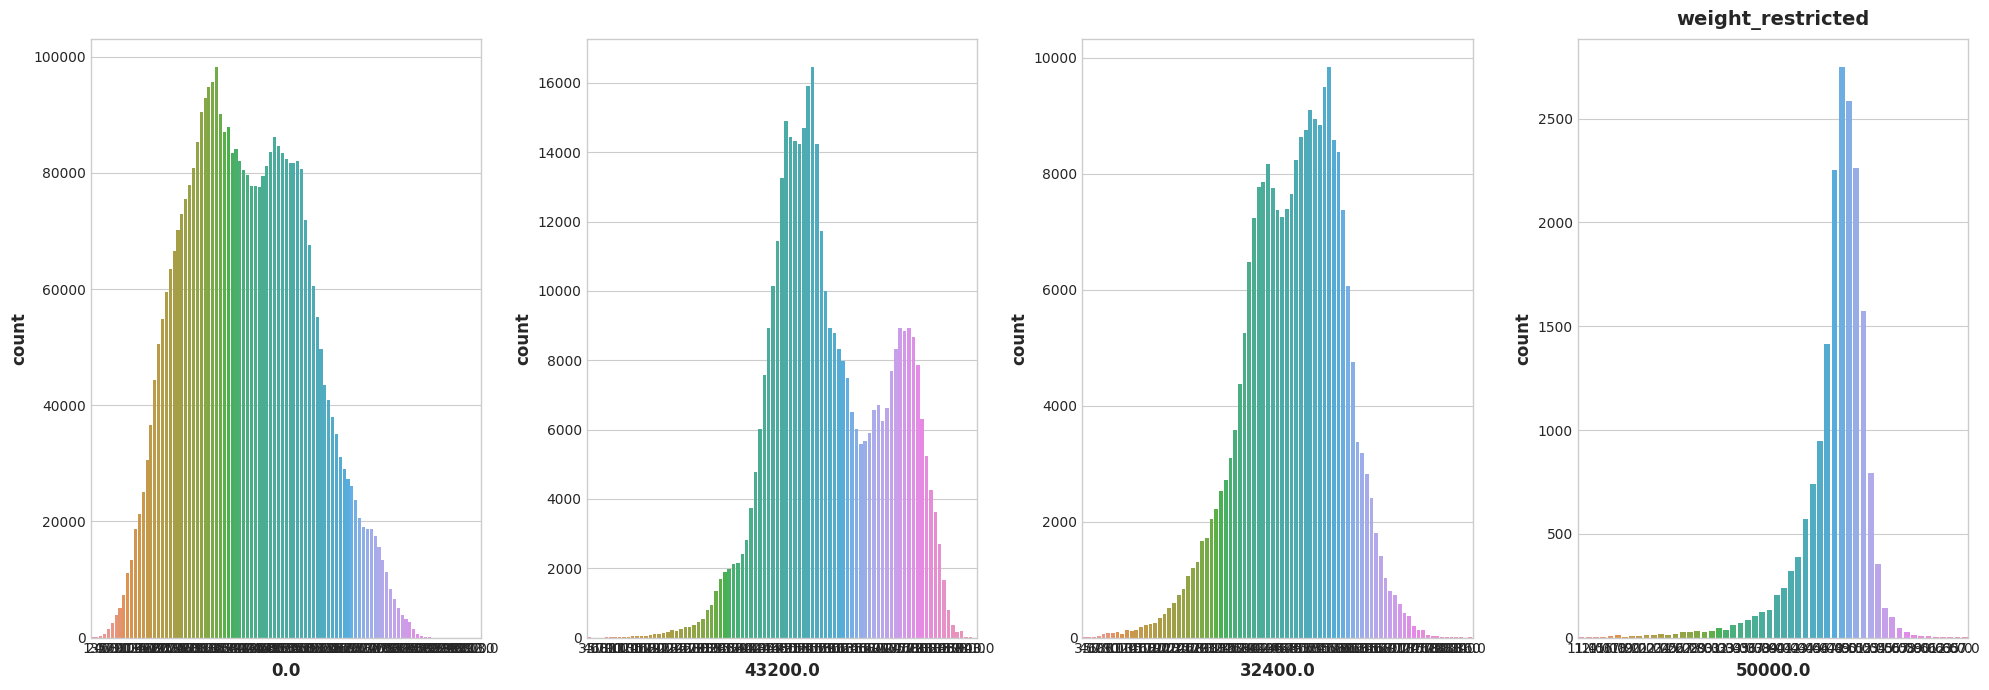

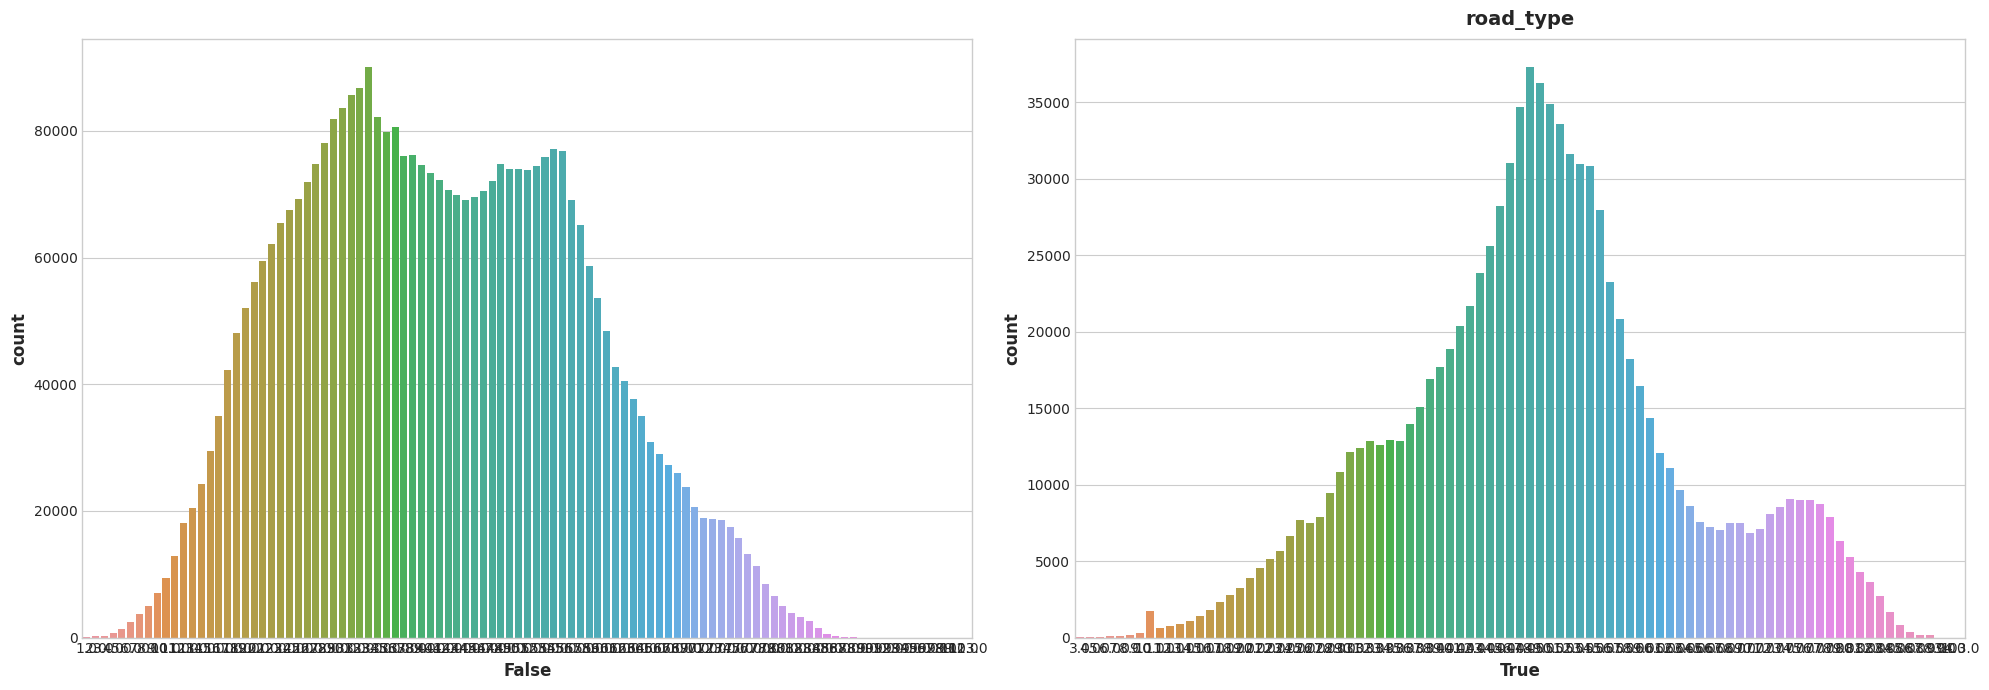

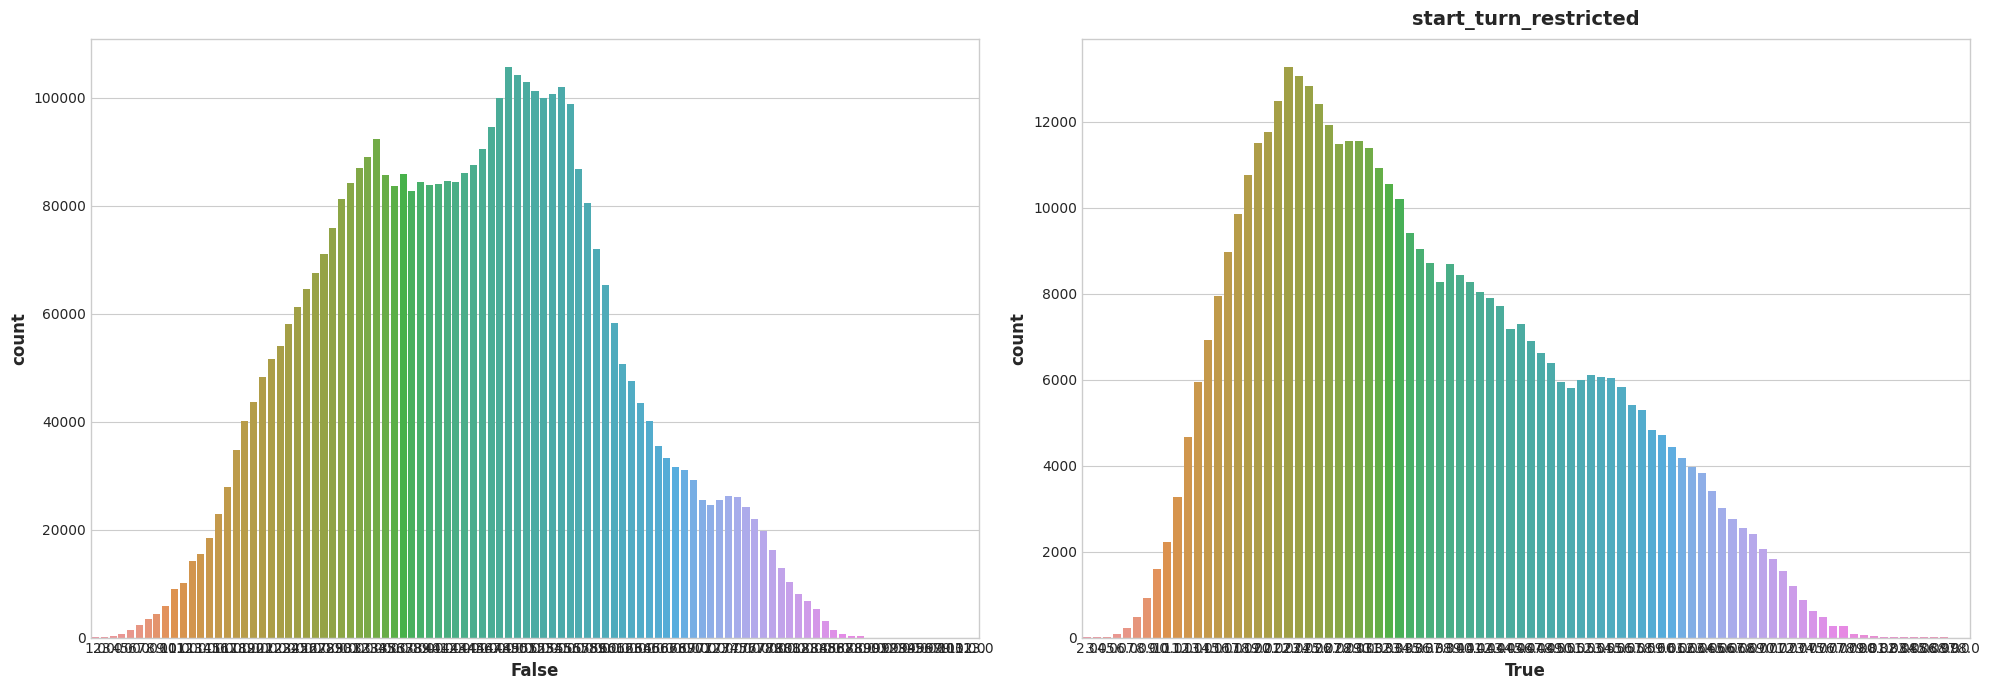

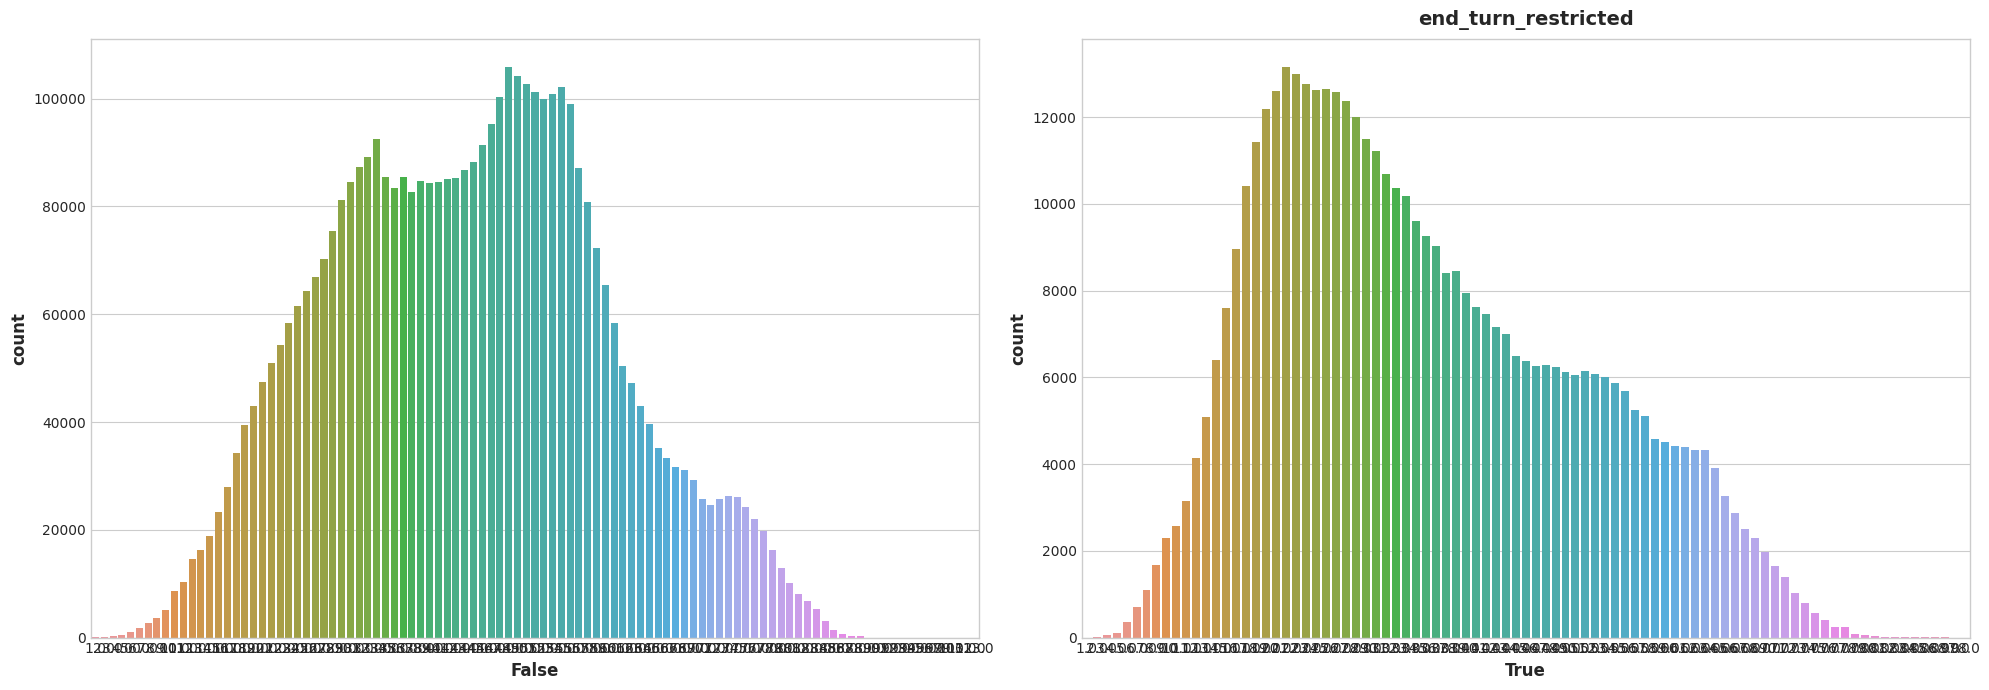

In [ ]:
def targetshow(x):
    fig, axes = plt.subplots(1, X_train[x].nunique(), figsize=(20, 7))

    data = pd.concat([X_train, y_train], axis = 1)
    values = data[x].value_counts().index.values
    
    for value, ax in zip(values, axes.flatten()):
        _data = data[data[x] == value]
        _data[value] = _data['target']

        sns.countplot(x=value, data=_data, ax=ax)
    
    plt.title(x)
 
a = X_train.nunique()

for col in a[a < 10].index.values:
    targetshow(col)


### Encoding & Feature generation

In [ ]:
X_train_catb = X_train
X_test_catb = X_test

In [ ]:
X_train.nunique()

base_date                170
day_of_week                7
base_hour                 24
lane_count                 3
road_rating                3
road_name                 61
multi_linked               2
connect_code               2
maximum_speed_limit        6
weight_restricted          4
road_type                  2
start_node_name          487
start_turn_restricted      2
end_node_name            487
end_turn_restricted        2
latitude                 457
longitude                457
dtype: int64

Target encoding

In [ ]:
t_enc = TargetEncoder()
tenc_features = ['road_name', 'start_node_name', 'end_node_name']

X_train[tenc_features] = t_enc.fit_transform(X_train[tenc_features], y_train)
X_test[tenc_features] = t_enc.transform(X_test[tenc_features])

X_train.head()

/usr/local/lib/python3.10/dist-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/usr/local/lib/python3.10/dist-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted,latitude,longitude
0,738113,thu,17,1,106,47.291909,False,False,60.0,32400.0,True,48.697943,False,50.298219,False,33.427748,126.662474
1,738130,thu,21,2,103,39.990158,False,False,60.0,0.0,False,26.400712,True,26.400712,False,33.502771,126.527673
2,737783,sun,7,2,103,44.365146,False,False,80.0,0.0,False,59.101720,False,65.118140,False,33.279609,126.365373
3,738065,fri,13,2,107,25.030004,False,False,50.0,0.0,False,23.755158,False,25.445418,False,33.245823,126.566716
4,737778,tue,8,2,103,43.530979,False,False,80.0,0.0,False,39.873670,False,48.109782,False,33.462446,126.328351


One-hot encoding

In [ ]:
# 2~5 6~9 10~13 14~17 18~21 22~1
X_train['base_hour_0'] = X_train['base_hour'].apply(lambda x : 1 if (x>1 and x<6) else 0)
X_train['base_hour_1'] = X_train['base_hour'].apply(lambda x : 1 if (x>5 and x<10) else 0)
X_train['base_hour_2'] = X_train['base_hour'].apply(lambda x : 1 if (x>9 and x<14) else 0)
X_train['base_hour_3'] = X_train['base_hour'].apply(lambda x : 1 if (x>13 and x<18) else 0)
X_train['base_hour_4'] = X_train['base_hour'].apply(lambda x : 1 if (x>17 and x<22) else 0)
X_train['base_hour_5'] = X_train['base_hour'].apply(lambda x : 1 if (x>21 or x<2) else 0)                            

X_test['base_hour_0'] = X_test['base_hour'].apply(lambda x : 1 if (x>1 and x<6) else 0)
X_test['base_hour_1'] = X_test['base_hour'].apply(lambda x : 1 if (x>5 and x<10) else 0)
X_test['base_hour_2'] = X_test['base_hour'].apply(lambda x : 1 if (x>9 and x<14) else 0)
X_test['base_hour_3'] = X_test['base_hour'].apply(lambda x : 1 if (x>13 and x<18) else 0)
X_test['base_hour_4'] = X_test['base_hour'].apply(lambda x : 1 if (x>17 and x<22) else 0)
X_test['base_hour_5'] = X_test['base_hour'].apply(lambda x : 1 if (x>21 or x<2) else 0)

X_train = X_train.drop('base_hour', axis = 1)
X_test = X_test.drop('base_hour', axis = 1)

X_train.head(10)

,base_date,day_of_week,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,...,end_node_name,end_turn_restricted,latitude,longitude,base_hour_0,base_hour_1,base_hour_2,base_hour_3,base_hour_4,base_hour_5
0,738113,thu,1,106,47.291909,False,False,60.0,32400.0,True,...,50.298219,False,33.427748,126.662474,0,0,0,1,0,0
1,738130,thu,2,103,39.990158,False,False,60.0,0.0,False,...,26.400712,False,33.502771,126.527673,0,0,0,0,1,0
2,737783,sun,2,103,44.365146,False,False,80.0,0.0,False,...,65.118140,False,33.279609,126.365373,0,1,0,0,0,0
3,738065,fri,2,107,25.030004,False,False,50.0,0.0,False,...,25.445418,False,33.245823,126.566716,0,0,1,0,0,0
4,737778,tue,2,103,43.530979,False,False,80.0,0.0,False,...,48.109782,False,33.462446,126.328351,0,1,0,0,0,0
5,737774,mon,2,107,24.686785,False,False,60.0,0.0,False,...,21.178734,False,33.251066,126.505866,0,1,0,0,0,0
6,738036,thu,2,107,44.774556,False,False,60.0,0.0,False,...,36.804945,False,33.416293,126.268703,0,0,0,0,0,1
7,737810,mon,2,107,40.872412,False,False,60.0,0.0,True,...,40.872412,False,33.482362,126.441944,0,0,0,1,0,0
8,737777,mon,2,107,24.686785,False,False,60.0,0.0,False,...,21.178734,False,33.252629,126.506231,0,0,0,1,0,0
9,737805,wed,1,103,44.365146,False,False,50.0,0.0,False,...,56.404230,False,33.363026,126.768183,1,0,0,0,0,0


In [ ]:
oh_enc = OneHotEncoder()

a = X_train.nunique()
oh_features = ['day_of_week', 'lane_count', 'road_rating', 'weight_restricted']

week = oh_enc.fit_transform(X_train[oh_features]).toarray()
categories = np.concatenate(oh_enc.categories_)
X_train = pd.concat([X_train, pd.DataFrame(week, columns = categories).astype('int64')], axis = 1)

week2 = oh_enc.transform(X_test[oh_features]).toarray()
X_test = pd.concat([X_test, pd.DataFrame(week2, columns = categories).astype('int64')], axis = 1)

NameError: name 'OneHotEncoder' is not defined

In [ ]:
X_train = X_train.drop(oh_features, axis = 1)
X_test = X_test.drop(oh_features, axis = 1)

### Scaling

In [ ]:
scaler = StandardScaler()
scaling_features = ['base_date', 'road_name', 'maximum_speed_limit', 'start_node_name', 'end_node_name', 'longitude', 'latitude']

scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train[scaling_features]), columns = scaling_features)
scaled_X_test = pd.DataFrame(scaler.transform(X_test[scaling_features]), columns = scaling_features)

X_train[scaling_features] = scaled_X_train
X_test[scaling_features] = scaled_X_test

X_train.describe()


,base_date,road_name,maximum_speed_limit,start_node_name,end_node_name,latitude,longitude,base_hour_0,base_hour_1,base_hour_2,...,1,2,3,103,106,107,0.0,32400.0,43200.0,50000.0
count,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,...,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06
mean,1.601019e-13,-3.249656e-15,2.152735e-16,-8.807240e-16,2.219637e-15,6.861567e-14,7.352077e-13,1.428719e-01,1.692500e-01,1.788816e-01,...,3.315165e-01,5.003156e-01,1.681679e-01,4.593515e-01,2.040944e-01,3.365541e-01,8.578362e-01,5.090278e-02,8.728825e-02,3.972801e-03
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.499422e-01,3.749726e-01,3.832531e-01,...,4.707583e-01,5.000000e-01,3.740154e-01,4.983450e-01,4.030383e-01,4.725309e-01,3.492181e-01,2.197992e-01,2.822570e-01,6.290484e-02
min,-1.445725e+00,-2.651645e+00,-2.575777e+00,-2.291715e+00,-2.273759e+00,-1.385321e+00,-2.157364e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-1.182649e+00,-2.685654e-01,-9.274536e-01,-8.507829e-01,-8.154059e-01,-1.188063e+00,-6.414953e-01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020049e-01,7.126505e-02,-1.032916e-01,-8.207784e-02,-2.361304e-02,2.841536e-01,-6.809255e-02,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.366406e-01,1.906174e-01,7.208704e-01,7.907830e-01,7.875338e-01,9.236969e-01,4.135840e-01,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.192149e+00,2.654189e+00,1.545032e+00,2.800400e+00,2.778444e+00,1.685108e+00,2.585372e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Feature Selection

In [ ]:
'''
discrete_features = X_train.dtypes == 'int64'
mi_scores = mutual_info_regression(X_train, y_train, discrete_features=discrete_features, random_state=0)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=True)
mi_scores
'''

'\ndiscrete_features = X_train.dtypes == \'int64\'\nmi_scores = mutual_info_regression(X_train, y_train, discrete_features=discrete_features, random_state=0)\nmi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)\nmi_scores = mi_scores.sort_values(ascending=True)\nmi_scores\n'

In [ ]:
'''
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
'''

'\nwidth = np.arange(len(mi_scores))\nticks = list(mi_scores.index)\nplt.barh(width, mi_scores)\nplt.yticks(width, ticks)\nplt.title("Mutual Information Scores")\n'

In [ ]:
'''
# threshold 0 : 0.8021 / 0.001 : 0.8029 / 0.005: 0.8027
drop_features = mi_scores[mi_scores < 0].index
X_train = X_train.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)
'''

'\n# threshold 0 : 0.8021 / 0.001 : 0.8029 / 0.005: 0.8027\ndrop_features = mi_scores[mi_scores < 0].index\nX_train = X_train.drop(drop_features, axis=1)\nX_test = X_test.drop(drop_features, axis=1)\n'

### Modeling and Scoring

LGBM

In [ ]:
# grid search
params = {
    'learning_rate' : [0.01, 0.04, 0.07, 0.1],
    'n_estimators' : [100, 300, 500, 1000],
    'max_depth' : [5, 7]
}

model = lgbm.LGBMRegressor()
grid_lgbm = GridSearchCV(model, param_grid=params, scoring = 'neg_mean_absolute_error', cv=3, refit=True)
grid_lgbm.fit(X_train, y_train)

print('best params : ', grid_lgbm.best_params_)
print('best score : ', grid_lgbm.best_score_)

best params :  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}
best score :  -3.911789582403442


best  
0.1 / 1000 / 7 -> 3.911

Catboost

In [ ]:
X_train_catb.info()
cat_features = ['day_of_week', 'base_hour', 'lane_count', 'road_rating', 'road_name', 'multi_linked', 'connect_code', 'road_type', 'start_node_name', 'start_turn_restricted', 'end_node_name', 'end_turn_restricted']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   base_date              int64  
 1   day_of_week            object 
 2   base_hour              int64  
 3   lane_count             int64  
 4   road_rating            int64  
 5   road_name              object 
 6   multi_linked           bool   
 7   connect_code           bool   
 8   maximum_speed_limit    float64
 9   weight_restricted      float64
 10  road_type              bool   
 11  start_node_name        object 
 12  start_turn_restricted  bool   
 13  end_node_name          object 
 14  end_turn_restricted    bool   
 15  latitude               float64
 16  longitude              float64
dtypes: bool(5), float64(4), int64(4), object(4)
memory usage: 452.8+ MB


In [ ]:
params = {
    'learning_rate' : [0.07, 0.1],
    'iterations' : [500],
    'depth' : [7]
}

model = catb.CatBoostRegressor(cat_features = cat_features)

grid_catb = GridSearchCV(model, param_grid=params, scoring = 'neg_mean_absolute_error', cv=3, refit=True)
grid_catb.fit(X_train_catb, y_train)

print('best params : ', grid_catb.best_params_)
print('best score : ', grid_catb.best_score_)

NameError: name 'catb' is not defined

### Submission

In [ ]:
y_test = grid_lgbm.best_estimator_.predict(X_test)
submission = pd.DataFrame(y_test, columns=['target'])
submission = pd.concat([test['id'], submission], axis=1)
submission.head()

,id,target
0,TEST_000000,26.091101
1,TEST_000001,41.932402
2,TEST_000002,60.260213
3,TEST_000003,36.857740
4,TEST_000004,39.034110


In [ ]:
submission.to_csv('./submission.csv', index=False)